# Parameter estimation - Real world data fitting
---

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import time
pd.set_option('display.max_rows', 999)
pd.set_option('display.width', 500)
pd.set_option('display.notebook_repr_html', True)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from matplotlib import rcParams
rcParams["font.size"] = 14
rcParams["axes.labelsize"] = "medium"
rcParams["xtick.labelsize"] = "medium"
rcParams["ytick.labelsize"] = "medium"
rcParams["legend.fontsize"] = "small"

### Load and merge data to fit against

In [3]:
data = pd.read_csv('data/NCHS_-_Drug_Poisoning_Mortality_by_State__United_States (1).csv')
data.columns = [u'Year', u'Sex', u'Age', u'Race', u'State', 
                u'Deaths', u'Population', u'Crude Death Rate', 
                u'Standard Error for Crude Rate', u'Low Confidence Limit for Crude Rate', 
                u'Upper Confidence Limit for Crude Rate', u'Age-adjusted Rate', 
                u'Standard Error Age-adjusted Rate', 
                u'Lower Confidence Limit for Age-adjusted rate', 
                u'Upper Confidence Limit for Age-adjusted Rate', 
                u'State Crude Rate in Range', u'US Crude Rate', 
                u'US Age-adjusted Rate']

data = data.query('Age== "All Ages" & Sex=="Both Sexes" & Race=="All Races-All Origins" & State!="United States"')

data['Deaths'] = data['Deaths'].apply(lambda x: x.replace(',',''))
data['Deaths'] = pd.to_numeric(data['Deaths'], errors='coerce')
data['Population'] = data['Population'].apply(lambda x: x.replace(',',''))
data['Population'] = pd.to_numeric(data['Population'], errors='coerce')
data['Age-adjusted Rate'] = data['Age-adjusted Rate']*data['Population']/100000

yearly_deaths = data.groupby(['Year'])['Deaths'].sum()

In [4]:
# Load and join opioid timeseries

opioids_kenan = pd.read_csv("data/opioid_prescriptions_kenan_et_al.csv")

opioids_cdc = pd.read_csv("data/opioid_prescriptions_cdc.csv")
opioids_cdc.columns = ["year", "prescriptions", "prescription_rate_per_100"]
opioids_cdc = opioids_cdc[["year", "prescription_rate_per_100"]]

opioids = pd.concat([
    opioids_kenan[opioids_kenan.year < 2006],
    opioids_cdc]).set_index("year")

# merge with pop data
pop = pd.read_csv("data/census_yearly_population.csv").set_index("year") * 1000

df = opioids.join(pop, how="left")
df["prescriptions"] = (df.population / 100) * df.prescription_rate_per_100

df["prescribed_population"] = df.prescriptions / 3.6
df["prescribed_population_percent"] = (df.prescriptions / 3.6) / df.population

# Merge with deaths
df = df.join(yearly_deaths).rename(columns={"Deaths": "deaths"})
df["opioid_death_rate"] = df.deaths / df.population

df = df.reset_index()[df.reset_index().year != 2016]

df.year = df.year.astype(int)

df.deaths = df.deaths.astype(int)

#print(df[["year", "population", "prescribed_population", "deaths"]].to_latex())
#df[["year", "population", "prescribed_population", "deaths"]].to_csv("merged_data.csv", index=False)
df[["year", "population", "prescribed_population", "deaths"]]

,year,population,prescribed_population,deaths
0,2000,2.822959e+08,4.852353e+07,17415
1,2001,2.852159e+08,5.083974e+07,19394
2,2002,2.880190e+08,5.212344e+07,23518
3,2003,2.907333e+08,5.414101e+07,25785
4,2004,2.933886e+08,5.688479e+07,27424
5,2005,2.961149e+08,6.040744e+07,29813
6,2006,2.989299e+08,6.011813e+07,34425
7,2007,3.019032e+08,6.365125e+07,36010
8,2008,3.047180e+08,6.619152e+07,36450
9,2009,3.073738e+08,6.787837e+07,37004


This represents our final time series that we expect our model to mimic.

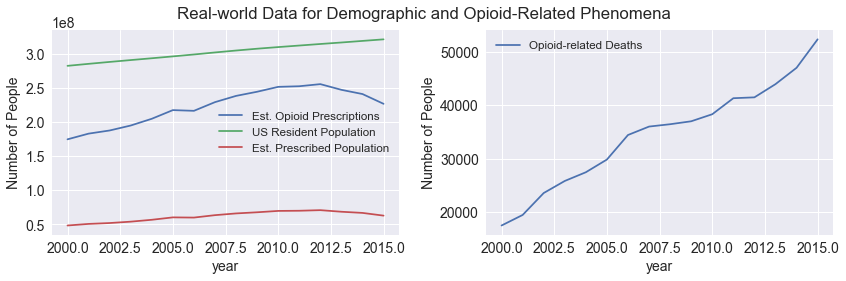

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

df.plot("year", "prescriptions", ax=ax[0], label="Est. Opioid Prescriptions")
df.plot("year", "population", ax=ax[0], label="US Resident Population")
df.plot("year", "prescribed_population", ax=ax[0], label="Est. Prescribed Population")
ax[0].set_ylabel("Number of People")

df.plot("year", "deaths", ax=ax[1], label="Opioid-related Deaths")
ax[1].set_ylabel("Number of People")

plt.suptitle("Real-world Data for Demographic and Opioid-Related Phenomena")

plt.tight_layout()

Now we can define our initial conditions and our modified model:

In [6]:
SPAR0 = [0.81, 0.17, 0.0045, 0.0155]

In [ ]:
def opioid_ours(state, t, epsilon, alpha, beta_1, beta_2, gamma, zeta, delta, mu, mu_star):
    
    '''
    modification 1: nu A is assumed to be 1 - sigma - delta - mu
    
    modification 2: beta and xi are replaced with beta_1 and beta_2 
    
    epsilon may also be assumed to be 1 - gamma to simplify parameter space, but is not employed here
    
    '''
    S, P, A, R = state
    # System of differential equations
    S_prime = -alpha*S - beta_1*S*A - beta_2*S*P + (epsilon)*P + delta*R + mu*(P+R) + mu_star*A
    P_prime = alpha*S - (epsilon + gamma + mu)*P
    A_prime = gamma*P + beta_1*S*A + beta_2*S*P + R*(1 - delta - mu) - (zeta + mu_star)*A
    R_prime = zeta*A - R
    
    # Return derivatives
    return [S_prime, P_prime, A_prime, R_prime]

Here is our objective function, with our error formulation:

In [453]:
def relative_error(actual, approx):
    return np.abs((actual - approx) / actual)

def integrated_model(params):
    
    state0 = SPAR0
    t = np.linspace(0, 16, 16)
    
    alpha, beta_1, beta_2, gamma, zeta, delta, sigma, epsilon = params
    
    numerical_sol = sp.integrate.odeint(opioid_ours, state0, t,
                                        args=(epsilon, alpha, beta_1, beta_2, gamma, zeta, delta, mu, mu_star))

    opioid_deaths = numerical_sol[:,2] * (mu_star - mu)    
    P = numerical_sol[:,1]
    
    deaths_error = relative_error(actual[:, 0], opioid_deaths)
    prescribed_error = relative_error(actual[:, 1], P)
    
    # calculate total relative error
    return np.sum(deaths_error) + np.sum(prescribed_error)

Now we can run our minimzation routine with initial guesses and bounds for the parameters, using a multi-start approach.

In [404]:
# parameters
epsilon = 0.74 # Prescribed to Susceptible rate
gamma = 0.26 # rate of addiction among prescribed users
gamma = 0.08
sigma = 0.7 # natural relapse rate of R 
mu = 0.00824 # death rate
mu_star = 0.023 #0.0235275 what I think it should be
delta = 0.6 # R to S rate. 0.1 is default
beta_1 = 0.0625 # total addiction rate for Susceptible due to illegal access
beta_2 = 0.0625 # total addiction rate for Susceptible due to illegal access
alpha = 0.3 # prescription rate. could be 0-1
zeta = 0.7 # rate of A entry into rehab. could be 0-1

# real world data
actual = df[["opioid_death_rate", "prescribed_population_percent"]].values

# bounds for parameters being optimized
bounds_reasonable = [(0, 0.5), (0.0001, 0.5), (0.0001, 0.5), (0.01, 0.6), (0, 1), (0,0.8), (0, 0.8), (0, 0.8)]
bounds_zeroone = [(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]

# Bounds we'll use
bounds = bounds_reasonable

# Try first with known realworld-ish parameters
ret = sp.optimize.minimize(integrated_model,
                     (alpha, beta_1, beta_2, gamma, zeta, delta, sigma, epsilon),
                     bounds=bounds,
                     method="TNC",
                     options={"maxiter": 4000}
                     )


best_fit = ret

# Do multistarts
for i in range(10):

    #params0 = np.random.rand(8)
    params0 = np.array([np.random.uniform(low=bound[0], high=bound[1]) for bound in bounds])

    ret = sp.optimize.minimize(integrated_model,
                     params0,
                     bounds=bounds,
                     method="TNC",
                     options={"maxiter": 4000}
                     )
    
    if ret.fun < best_fit.fun:
        best_fit = ret

In [405]:
best_fit

     fun: 2.8835227261775063
     jac: array([   6.43970282,    3.78296314,  128.27378355,  156.70013145,
          0.22702467,   -4.66057561,    0.        ,    1.17557488])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 226
     nit: 21
  status: 1
 success: True
       x: array([  1.10192012e-01,   2.54363424e-01,   1.00000000e-04,
         1.00000000e-02,   5.27351734e-01,   8.00000000e-01,
         7.97886856e-01,   3.87202182e-01])

We obtain the following parameter results:

In [412]:
pd.DataFrame(best_fit.x,
             index=["alpha", "beta_1", "beta_2", "gamma", "zeta", "delta", "sigma", "epsilon"],
            columns=["Values"]
            )

,Values
alpha,0.110192
beta_1,0.254363
beta_2,0.000100
gamma,0.010000
zeta,0.527352
delta,0.800000
sigma,0.797887
epsilon,0.387202


We can now run a simulation with the given parameters and intial conditions:

In [407]:
t = np.linspace(0, 16, 16)

alpha, beta_1, beta_2, gamma, zeta, delta, sigma, epsilon = ret.x

numerical_sol = sp.integrate.odeint(opioid_ours, SPAR0, t,
                                    args=(epsilon, alpha, beta_1, beta_2, gamma, zeta, delta, mu, mu_star)
                                   )

S = numerical_sol[:,0]
P = numerical_sol[:,1]
A = numerical_sol[:,2]
R = numerical_sol[:,3]

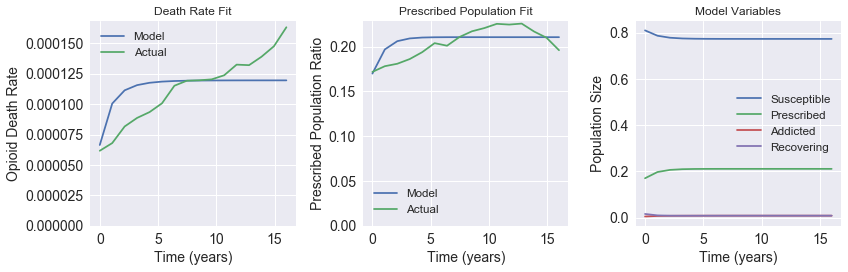

In [459]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].plot(t, (mu_star-mu)*A, label="Model")
ax[0].plot(t, df.opioid_death_rate, label = "Actual")
ax[0].set_ylim(ymin=0)
ax[0].set_xlabel("Time (years)")
ax[0].set_ylabel("Opioid Death Rate")
ax[0].set_title("Death Rate Fit")
ax[0].legend()

ax[1].plot(t, P, label="Model")
ax[1].plot(t, df.prescribed_population_percent, label = "Actual")
ax[1].set_ylim(ymin=0)
ax[1].set_xlabel("Time (years)")
ax[1].set_ylabel("Prescribed Population Ratio")
ax[1].set_title("Prescribed Population Fit")
ax[1].legend()

ax[2].plot(t, S, label="Susceptible")
ax[2].plot(t, P, label= "Prescribed")
ax[2].plot(t, A, label= "Addicted")
ax[2].plot(t, R, label= "Recovering")
#plt.plot(t, (mu_star-mu)*A, label="Deaths")
ax[2].set_title("Model Variables")
ax[2].set_xlabel("Time (years)")
ax[2].set_ylabel("Population Size")
ax[2].legend()

plt.tight_layout()